In [32]:
# !wget https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip

--2024-01-09 10:29:38--  https://www.dropbox.com/s/tlxserrdhe240lu/archive.zip
Resolving www.dropbox.com (www.dropbox.com)... 162.125.2.18, 2620:100:6017:18::a27d:212
Connecting to www.dropbox.com (www.dropbox.com)|162.125.2.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/tlxserrdhe240lu/archive.zip [following]
--2024-01-09 10:29:38--  https://www.dropbox.com/s/raw/tlxserrdhe240lu/archive.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uca0a030e85a2ea6c740b34882dc.dl.dropboxusercontent.com/cd/0/inline/CLDyhICoo6rf0BAgrnc9Ymz5vwTbe3kaYjE8oDZIWKm2aqh-2h1_NyfzYheecgaSlYXdceQd7MgW_fzzmrTOY5fGmf3R8Xzasn2wi6pK-LlrRQuYbqkamHh98DURmi9ESG55NgeJF-thk4zQXLOSJItX/file# [following]
--2024-01-09 10:29:38--  https://uca0a030e85a2ea6c740b34882dc.dl.dropboxusercontent.com/cd/0/inline/CLDyhICoo6rf0BAgrnc9Ymz5vwTbe3kaYjE8oDZIWKm2aqh-2h1_NyfzYheecgaSlYXdceQd7MgW_fzzmrTOY5fGmf3R8Xzasn2wi6pK-

In [33]:
!unzip -q "archive.zip"

### Tensorflow use to build the deep learning models.


In [34]:
# imports required libraries for this project.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [35]:
# Creating pathlib path object
train_path = Path('/content/chest_xray/train')
validation_path = Path('/content/chest_xray/val')
test_path = Path('/content/chest_xray/test')

### Datapath object has the method called glob which iterate over file in directory which matches the given pattern.

In [36]:
### Collection all the paths present inside 'Normal' and 'Pneumonia' folder
train_image_paths = train_path.glob("*/*")
val_image_paths = validation_path.glob("*/*")

# output is generator object
print(train_image_paths)

<generator object Path.glob at 0x7c82a57e90e0>


In [37]:
### Pathlib glob method return the generator object.

In [38]:
# Coverting the generator object into list of element.
train_image_paths = list(train_image_paths)
val_image_paths = list(val_image_paths)

# Now all path in Posixpath
print(train_image_paths)

[PosixPath('/content/chest_xray/train/NORMAL/IM-0588-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-1245-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-1310-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-1314-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-1242-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-0749-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/IM-0747-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/IM-0596-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/IM-0640-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-1345-0001-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/IM-0581-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-1113-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-0506-0001.jpeg'), PosixPath('/content/chest_xray/train/NORMAL/NORMAL2-IM-0868-0001.jpeg'), PosixPath('/

In [39]:
# Coverting all the paths into normal strings
train_image_paths = list(map(lambda x: str(x), train_image_paths))
val_image_paths = list(map(lambda x: str(x), val_image_paths))

print(train_image_paths[:3])

['/content/chest_xray/train/NORMAL/IM-0588-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-1245-0001.jpeg', '/content/chest_xray/train/NORMAL/NORMAL2-IM-1310-0001.jpeg']


In [40]:
# Collecting training and validation dataset lenght.
train_dataset_length = len(train_image_paths)
val_dataset_length = len(val_image_paths)

print(train_dataset_length)
print(val_dataset_length)

5216
16


In [41]:
# Every image has the lable in its path, so lets slict it.
LABELS = {'NORMAL' : 0, 'PNEUMONIA': 1}
INV_LABELS = {0 : 'NORMAL', 1 : 'PNEUMONIA'}

def get_label(path: str):
  return LABELS[path.split("/")[-2]]

train_labels = list(map(lambda x: get_label(x), train_image_paths))
val_labels = list(map(lambda x: get_label(x), val_image_paths))

print(train_labels[-10:])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [42]:
# Now we have all the image and there respective labels
BATCH_SIZE = 32

# Function used for transform
def load_and_transform(image,lable,train):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [224,224], method = 'nearest')

  if train:
    image = tf.image.random_flip_left_right(image)
  return image,lable

In [43]:
def get_dataset(path,labels,train = True):
  image_path = tf.convert_to_tensor(path)
  image_lable = tf.convert_to_tensor(labels)

  image_dataset = tf.data.Dataset.from_tensor_slices(image_path)
  label_dataset = tf.data.Dataset.from_tensor_slices(image_lable)

  dataset = tf.data.Dataset.zip((image_dataset,label_dataset)).shuffle(1000)

  dataset = dataset.map(lambda image,label : load_and_transform(image,label,train))
  dataset = dataset.repeat() # infinitely iterate over complete dataset
  dataset = dataset.shuffle(2048) # applying one more shuffle
  dataset = dataset.batch(BATCH_SIZE) # Batch size is the count of image have to loaded at point of time during taining model.

 ## lower the batch size means less images will load at once and increase the training time.
 ## We have to choose optimal batch size to train faster.
  return dataset

In [44]:
# Creating train dataset object.
%time train_dataset = get_dataset(train_image_paths, train_labels)

image,label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 63.5 ms, sys: 6.94 ms, total: 70.4 ms
Wall time: 65.6 ms
(32, 224, 224, 3)
(32,)


In [45]:
# Creating train dataset object.
%time val_dataset = get_dataset(val_image_paths, val_labels)

CPU times: user 116 ms, sys: 29.8 ms, total: 146 ms
Wall time: 155 ms


PNEUMONIA


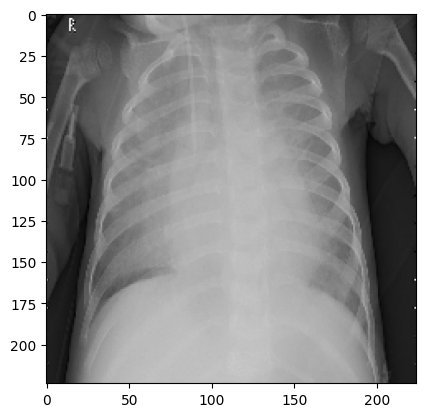

In [46]:
# View sample train image.
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224,224,3))

In [47]:
### Increasing the layers in CNN my lead to overfitting problem as it learn more information causes to vanising gradience.

### Overfitting problem can be handled by regularization and dropout where we disactivate few neurons at random.
### Vanising gradient problem can be handled by using RELU activation function
### If it maximize gradient flow then we can also use Batch Normalization.

In [48]:
# Building resnet model
from tensorflow.keras.applications import ResNet50V2

backbone = ResNet50V2(
    input_shape = (224,224,3),
    include_top = False
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model.summary()

94668760/94668760 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23566849 (89.90 MB)
Trainable params: 23521409 (89.73 MB)
Non-trainable params: 45440 (177.50 KB)
_________________________________________________________________


In [49]:
## Evaluating model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'binary_crossentropy', ## for sigle class we use binary for multi class we use categorical
    metrics=['accuracy' , tf.keras.metrics.Precision(name='precision'),tf.keras.metrics.Recall(name='recall')]
)

### Earlystopping callback

In [50]:
### Early stopping call back is use to avoid overfitting. which use the paitence parameter.
### paitence identify the epochs without any imporvement.
### or they have the higher loss then the start point.

### Model Callback

In [51]:
### used to save the models or weight at perticular frequency.

In [52]:
# Defining our callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5",verbose=1,save_best_only=True,save_weights_only = True)
# save_best_only will save the best models only
# save_weights_only will save the weights only if set to true else it will save the architecture of model with weight at each epochs.

early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [61]:
print(train_dataset_length//BATCH_SIZE)
print(val_dataset_length//BATCH_SIZE)

163
0


In [63]:
history = model.fit(
    train_dataset,
    steps_per_epoch=train_dataset_length//BATCH_SIZE,
    epochs=8,
    callbacks=[checkpoint , early_stop],
    validation_data=val_dataset,
    validation_steps =  5 #val_dataset_length//BATCH_SIZE,
)

Epoch 1/8
163/163 [==============================] - ETA: 0s - loss: 0.0554 - accuracy: 0.9785 - precision: 0.9861 - recall: 0.9815
Epoch 1: val_loss improved from 1.16483 to 0.92502, saving model to best_weights.h5
163/163 [==============================] - 125s 623ms/step - loss: 0.0554 - accuracy: 0.9785 - precision: 0.9861 - recall: 0.9815 - val_loss: 0.9250 - val_accuracy: 0.6938 - val_precision: 1.0000 - val_recall: 0.3378
Epoch 2/8
163/163 [==============================] - ETA: 0s - loss: 0.0408 - accuracy: 0.9862 - precision: 0.9912 - recall: 0.9901
Epoch 2: val_loss did not improve from 0.92502
163/163 [==============================] - 78s 481ms/step - loss: 0.0408 - accuracy: 0.9862 - precision: 0.9912 - recall: 0.9901 - val_loss: 4.9854 - val_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/8
163/163 [==============================] - ETA: 0s - loss: 0.0489 - accuracy: 0.9812 - precision: 0.9881 - recall: 0.9866
Epoch 3: val_loss improved from 0.92502 

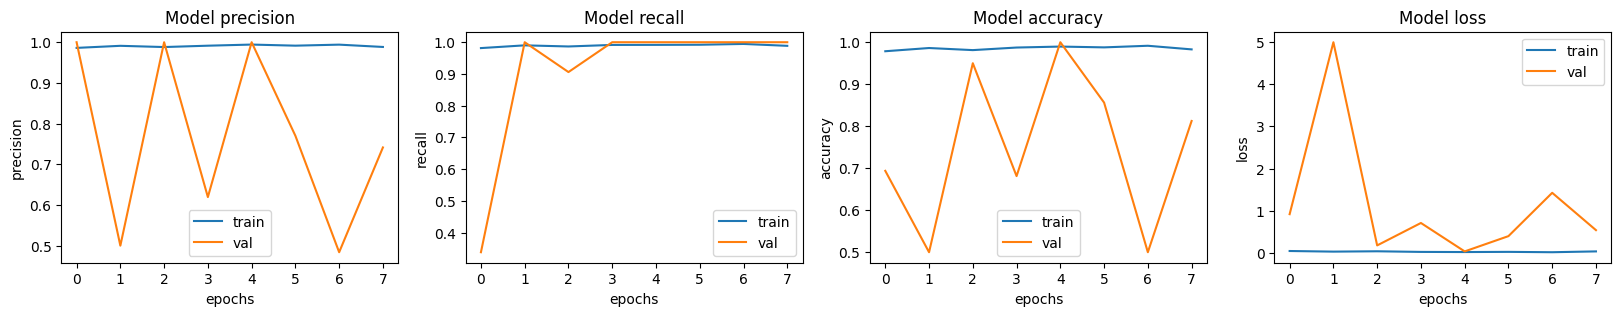

In [65]:
# Interpreting the Metrics
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [64]:
# Saving the best Model

# Load the best weights
model.load_weights("best_weights.h5")
# Save the whole model (weigths + architecture)
model.save("model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [66]:
# Loading the whole model
loaded_model = tf.keras.models.load_model("model.h5")


In [68]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x : str(x) , test_image_paths))
test_labels = list(map(lambda x : get_label(x) , test_image_paths))

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image , label):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image , channels = 3)
    image = tf.image.resize(image , [224 , 224] , method="nearest")
    return image , label

test_dataset = (
     tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE))

In [69]:
# Verify Test Dataset Object
image , label = next(iter(test_dataset))
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32,)


NORMAL


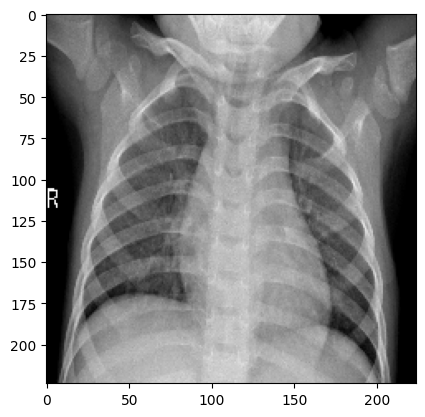

In [70]:
# View a sample Validation Image
print(INV_LABELS[label[0].numpy()])
plt.imshow(image[0].numpy().reshape(224 , 224 , 3))

In [71]:
# Evaluating the loaded model
loss, acc, prec, rec = loaded_model.evaluate(test_dataset)

print(" Testing Acc : " , acc)
print(" Testing Precision " , prec)
print(" Testing Recall " , rec)

20/20 [==============================] - 6s 253ms/step - loss: 0.4403 - accuracy: 0.8830 - precision: 0.8712 - recall: 0.9538
 Testing Acc :  0.8830128312110901
 Testing Precision  0.8711943626403809
 Testing Recall  0.9538461565971375
